# Tutorial 4: Exploring unimodal data

This tutorial demonstrates a new approach for analyzing unimodal single-cell data with Ocelli. The proposed workflow uses topic modeling to find relationships between features (topics). We treat each topic as a separate modality consisting of features that are highly specific to a topic. Using topic-based modalities significantly reduces noise in single-cell data.

## Pancreatic endocrinogenesis (RNA-seq)

This RNA-seq dataset consists of pancreatic developmental cells sampled from embryonic day 15.5. Data comes from [Bastidas-Ponce et al., 2019](https://journals.biologists.com/dev/article/146/12/dev173849/19483/Comprehensive-single-cell-mRNA-profiling-reveals-a). We used a count matrix available on [scVelo's website](https://scvelo.readthedocs.io/en/stable/scvelo.datasets.pancreas/#scvelo.datasets.pancreas). Our annotated matrix with filtered genes is available for download [here](https://figshare.com/articles/dataset/Ocelli_Tutorial_4_Exploring_unimodal_data/22700065).

### Loading and preprocessing data

In [1]:
import anndata as ad

adata = ad.read_h5ad('pancreas_RNAseq.h5ad')

adata

AnnData object with n_obs × n_vars = 3696 × 5465
    obs: 'celltype'
    layers: 'spliced', 'unspliced'

Data consists of 3,696 cells and 5,465 cells. The count matrix is stored in `adata.X`.

Compute LDA topics.

In [2]:
import ocelli as oci

SEED = 17

oci.pp.LDA(adata, n_components=20, verbose=1, max_iter=50, random_state=SEED)

iteration: 1 of max_iter: 50
iteration: 2 of max_iter: 50
iteration: 3 of max_iter: 50
iteration: 4 of max_iter: 50
iteration: 5 of max_iter: 50
iteration: 6 of max_iter: 50
iteration: 7 of max_iter: 50
iteration: 8 of max_iter: 50
iteration: 9 of max_iter: 50
iteration: 10 of max_iter: 50
iteration: 11 of max_iter: 50
iteration: 12 of max_iter: 50
iteration: 13 of max_iter: 50
iteration: 14 of max_iter: 50
iteration: 15 of max_iter: 50
iteration: 16 of max_iter: 50
iteration: 17 of max_iter: 50
iteration: 18 of max_iter: 50
iteration: 19 of max_iter: 50
iteration: 20 of max_iter: 50
iteration: 21 of max_iter: 50
iteration: 22 of max_iter: 50
iteration: 23 of max_iter: 50
iteration: 24 of max_iter: 50
iteration: 25 of max_iter: 50
iteration: 26 of max_iter: 50
iteration: 27 of max_iter: 50
iteration: 28 of max_iter: 50
iteration: 29 of max_iter: 50
iteration: 30 of max_iter: 50
iteration: 31 of max_iter: 50
iteration: 32 of max_iter: 50
iteration: 33 of max_iter: 50
iteration: 34 of ma

Training MDM on the RNA-seq's LDA embedding would result in standard, unimodal Diffusion Maps. While such an approach is perfectly valid, LDA provides additional information - variational parameters for gene-topic distribution. You can interpret these parameters as a pseudo count representing the assignment of genes to a topic. `oci.pp.LDA` saves these parameters to `adata.varm['X_lda']` as an array of shape `(n_var, n_topics)`.

In [3]:
adata.varm['X_lda'].shape

(5465, 20)

We propose to treat topics as modalities. `oci.pp.modality_generation` looks at parameters in `adata.varm['lda']` and assigns each gene to its highest-parameter topic. Grouped genes form new modalities. You can control the upper bound of the number of genes in each modality - the default value is 100. New modalities get log-normalized if `log_norm=True` in `oci.pp.modality_generation`.

In [4]:
oci.pp.modality_generation(adata, log_norm=True, verbose=True)

[modality0]	Modality generated.
[modality1]	Modality generated.
[modality2]	Modality generated.
[modality3]	Modality generated.
[modality4]	Modality generated.
[modality5]	Modality generated.
[modality6]	Modality generated.
[modality7]	Modality generated.
[modality8]	Modality generated.
[modality9]	Modality generated.
[modality10]	Modality generated.
[modality11]	Modality generated.
[modality12]	Modality generated.
[modality13]	Modality generated.
[modality14]	Modality generated.
[modality15]	Modality generated.
[modality16]	Modality generated.
[modality17]	Modality generated.
[modality18]	Modality generated.
[modality19]	Modality generated.
20 topic-based modalities generated.


``oci.pp.modality_generation`` automatically saves generated modality names to ``adata.uns['modalities']``.

In [5]:
adata.uns['modalities']

['modality0',
 'modality1',
 'modality2',
 'modality3',
 'modality4',
 'modality5',
 'modality6',
 'modality7',
 'modality8',
 'modality9',
 'modality10',
 'modality11',
 'modality12',
 'modality13',
 'modality14',
 'modality15',
 'modality16',
 'modality17',
 'modality18',
 'modality19']

`adata` includes unspliced and spliced gene expression layers. Employ them to calculate RNA velocities on 1,000 log-normalized highly variable genes. 

In [6]:
import scvelo as scv

scv.pp.normalize_per_cell(adata, counts_per_cell_after=10000)
scv.pp.filter_genes_dispersion(adata, n_top_genes=1000)
scv.pp.log1p(adata)

scv.tl.velocity(adata, mode='stochastic')
scv.tl.velocity_graph(adata)

Normalized count data: X, spliced, unspliced.
Extracted 1000 highly variable genes.
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/8 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:07) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


### Multimodal Diffusion Maps

Log-normalized modalities are ready for training a MDM model. The critical step in the analysis is to use LDA's cell-topic distribution (`adata.obsm['X_lda']`) as modalities' weights. It is a natural choice because distribution values 1) sum to 1 for each cell and 2) encode a degree of relevance of each modality (topic) to a cell. The significant advantage of such an approach is that a cell's embedding is influenced by topic-based modalities (consisting of topic-relevant genes) proportionally to the topics' relevance to a cell. This step dramatically reduces inherent single-cell noise.

`oci.pp.modality_generation` saves LDA-based weights to `adata.obsm['weights']`.

In [7]:
adata.obsm['weights']

,modality0,modality1,modality2,modality3,modality4,modality5,modality6,modality7,modality8,modality9,modality10,modality11,modality12,modality13,modality14,modality15,modality16,modality17,modality18,modality19
AAACCTGAGAGGGATA,0.002430,0.007674,0.007712,0.102145,0.002342,0.008317,0.001827,0.017973,0.007638,0.063900,0.049555,0.042434,0.094664,0.024815,0.079300,0.009830,0.371567,0.043714,0.020644,0.041521
AAACCTGAGCCTTGAT,0.001912,0.278708,0.002602,0.087956,0.001166,0.012176,0.001074,0.104506,0.012574,0.006301,0.026456,0.004610,0.243986,0.020106,0.000990,0.132102,0.003261,0.005555,0.032054,0.021906
AAACCTGAGGCAATTA,0.003665,0.012536,0.014184,0.013503,0.002706,0.020714,0.027890,0.077708,0.015388,0.063211,0.071690,0.151815,0.131225,0.030949,0.011694,0.034146,0.243392,0.008848,0.016192,0.048543
AAACCTGCATCATCCC,0.001046,0.118428,0.002715,0.029078,0.001066,0.012884,0.000936,0.110373,0.087123,0.003526,0.058260,0.003513,0.121219,0.007089,0.000843,0.418786,0.002353,0.003590,0.012426,0.004745
AAACCTGGTAAGTGGC,0.001827,0.010498,0.011332,0.030509,0.001866,0.085311,0.001635,0.018233,0.009816,0.182690,0.056825,0.012112,0.048607,0.120583,0.002015,0.012569,0.036090,0.297624,0.054869,0.004990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAAGTGACATA,0.001140,0.006241,0.021874,0.041146,0.001111,0.009308,0.001104,0.057680,0.013975,0.166825,0.046281,0.067421,0.092043,0.092049,0.000877,0.008964,0.200480,0.118638,0.042896,0.009948
TTTGTCAAGTGTGGCA,0.001294,0.002969,0.003524,0.102868,0.001158,0.113681,0.001086,0.025608,0.007960,0.009393,0.034449,0.004601,0.035406,0.106191,0.000895,0.118450,0.004743,0.262046,0.156797,0.006881
TTTGTCAGTTGTTTGG,0.002135,0.405979,0.002980,0.081686,0.001517,0.039509,0.001331,0.144264,0.009441,0.008396,0.067988,0.004884,0.069425,0.016991,0.001272,0.090794,0.003418,0.006730,0.022281,0.018983
TTTGTCATCGAATGCT,0.001022,0.002333,0.002794,0.117173,0.315331,0.025995,0.044490,0.095125,0.007444,0.020210,0.007918,0.129767,0.056801,0.009333,0.016400,0.022803,0.005755,0.028691,0.008228,0.082386


Calculate the MDM representation.

In [8]:
oci.pp.neighbors(adata, n_neighbors=20, verbose=True)
oci.tl.MDM(adata, n_components=25, random_state=SEED, verbose=True)

[modality0]	20 nearest neighbors calculated.
[modality1]	20 nearest neighbors calculated.
[modality2]	20 nearest neighbors calculated.
[modality3]	20 nearest neighbors calculated.
[modality4]	20 nearest neighbors calculated.
[modality5]	20 nearest neighbors calculated.
[modality6]	20 nearest neighbors calculated.
[modality7]	20 nearest neighbors calculated.
[modality8]	20 nearest neighbors calculated.
[modality9]	20 nearest neighbors calculated.
[modality10]	20 nearest neighbors calculated.
[modality11]	20 nearest neighbors calculated.
[modality12]	20 nearest neighbors calculated.
[modality13]	20 nearest neighbors calculated.
[modality14]	20 nearest neighbors calculated.
[modality15]	20 nearest neighbors calculated.
[modality16]	20 nearest neighbors calculated.
[modality17]	20 nearest neighbors calculated.
[modality18]	20 nearest neighbors calculated.
[modality19]	20 nearest neighbors calculated.


2023-02-26 14:56:48,473	INFO worker.py:1518 -- Started a local Ray instance.


[modality0]	Unimodal Markov chain calculated.
[modality1]	Unimodal Markov chain calculated.
[modality2]	Unimodal Markov chain calculated.
[modality3]	Unimodal Markov chain calculated.
[modality4]	Unimodal Markov chain calculated.
[modality5]	Unimodal Markov chain calculated.
[modality6]	Unimodal Markov chain calculated.
[modality7]	Unimodal Markov chain calculated.
[modality8]	Unimodal Markov chain calculated.
[modality9]	Unimodal Markov chain calculated.
[modality10]	Unimodal Markov chain calculated.
[modality11]	Unimodal Markov chain calculated.
[modality12]	Unimodal Markov chain calculated.
[modality13]	Unimodal Markov chain calculated.
[modality14]	Unimodal Markov chain calculated.
[modality15]	Unimodal Markov chain calculated.
[modality16]	Unimodal Markov chain calculated.
[modality17]	Unimodal Markov chain calculated.
[modality18]	Unimodal Markov chain calculated.
[modality19]	Unimodal Markov chain calculated.
Multimodal Markov chain calculated.
Eigendecomposition finished.
25 Mu

### Visualizing MDM components

Compute a 2D FLE embedding and plot it.

In [9]:
oci.pp.neighbors(adata, x=['X_mdm'], n_neighbors=100, verbose=True)
oci.tl.transitions_graph(adata, x='X_mdm', transitions='velocity_graph', n_edges=20, 
                         verbose=True)
oci.tl.FA2(adata, n_components=2, random_state=SEED)

[X_mdm]	100 nearest neighbors calculated.
Transitions-based graph constructed.


Feb 26, 2023 2:57:27 PM org.netbeans.modules.masterfs.watcher.Watcher getNotifierForPlatform
INFO: Native file watcher is disabled
Feb 26, 2023 2:57:27 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Nodes loaded: 3,696 (3,696 added)
Feb 26, 2023 2:57:27 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Edges loaded: 73,920 (70,815 added)


*************************25%
*************************50%
*************************75%
*************************100%
Time = 28.261s


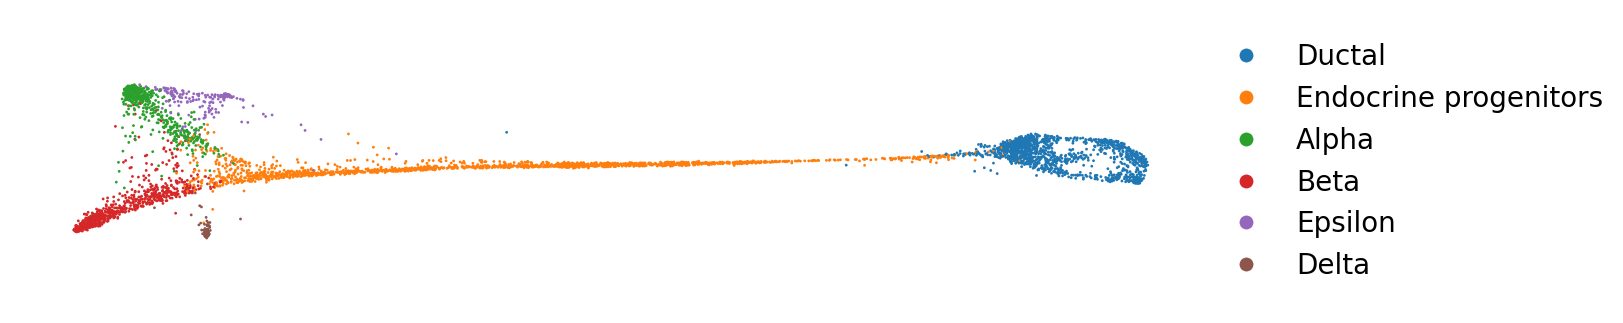

In [10]:
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 200

cdict = {'Ductal': '#1f77b4',
         'Endocrine progenitors': '#ff7f0e', 
         'Alpha': '#2ca02c', 
         'Beta': '#d62728', 
         'Epsilon': '#9467bd', 
         'Delta': '#8c564b'}

oci.pl.scatter(adata, x='X_fa2', c='celltype', cdict=cdict, markersize=1, title='', 
               fontsize=10, figsize=(8, 1.5))

The developmental process of the analyzed system has two significant stages:

* ductal cells form a cell cycle,
* endocrine progenitors differentiate into four lineages: Alpha, Beta, Epsilon, and Delta.

### Reconstructing the cell cycle of Ductal cells

Investigate the cell cycle of proliferative Ductal cells. The cell cycle consists of four repeating phases:

* M: mitosis (cell division),
* G1: cell growth,
* S: DNA synthesis,
* G2: cell growth and preparation for mitosis.

You can validate the cell cycle reconstruction by checking scores for cell cycle phases.

In [11]:
scv.tl.score_genes_cell_cycle(adata)

calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)


Plot scores for phase S.

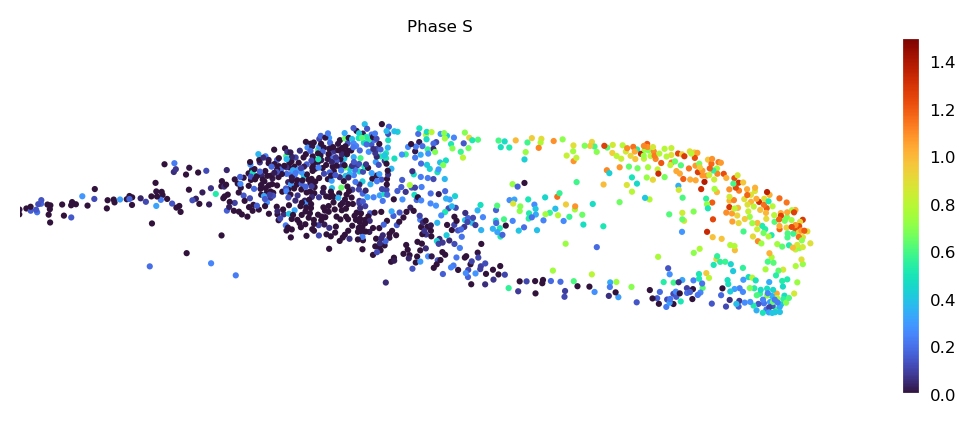

In [12]:
oci.pl.scatter(adata, x='X_fa2', c='S_score', cmap='turbo', markersize=5, vmin=0, 
               vmax=1.5, title='Phase S', xlim=[9500, 14000], ylim=[-900, 900], 
               figsize=(5, 2))

Plot scores for combined phases G2 and M.

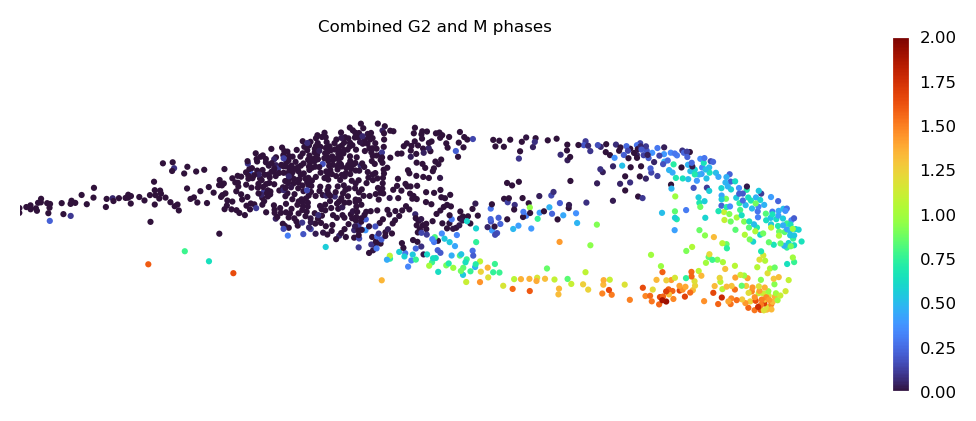

In [13]:
oci.pl.scatter(adata, x='X_fa2', c='G2M_score', cmap='turbo', markersize=5, vmin=0, 
               vmax=2, xlim=[9500, 14000], ylim=[-900, 900], figsize=(5, 2),
               title='Combined G2 and M phases')

Arrows of the velocity stream should point from high S-scoring cells toward high G2M-scoring cells.

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_fa2', embedded velocity vectors (adata.obsm)


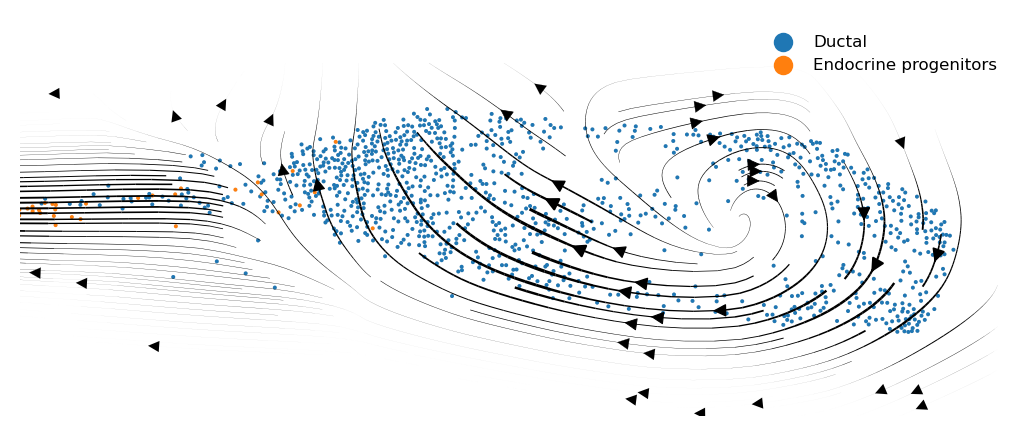

In [14]:
fig, ax = mpl.pyplot.subplots()

scv.pl.velocity_embedding_stream(adata, basis='fa2', alpha=1, title='', density=4, 
                                 xlim=[9500, 14000], ylim=[-900, 900], linewidth=1, 
                                 legend_fontsize=6, size=8, legend_loc='best', 
                                 groups=['Ductal', 'Endocrine progenitors'], 
                                 show=False, ax=ax,color='celltype', palette=cdict, 
                                 cutoff_perc=0)

ax.set_aspect('equal')

### Tracing the development of endocrine cells

Endocrine cells are derived from endocrine progenitors and form four significant lineages (studied in detail [here](https://www.nature.com/articles/s41422-021-00486-w)):

* glucagon-producing Alpha cells,
* insulin-producing Beta cells,
* somatostatin-producing Delta cells,
* ghrelin-producing Epsilon cells.

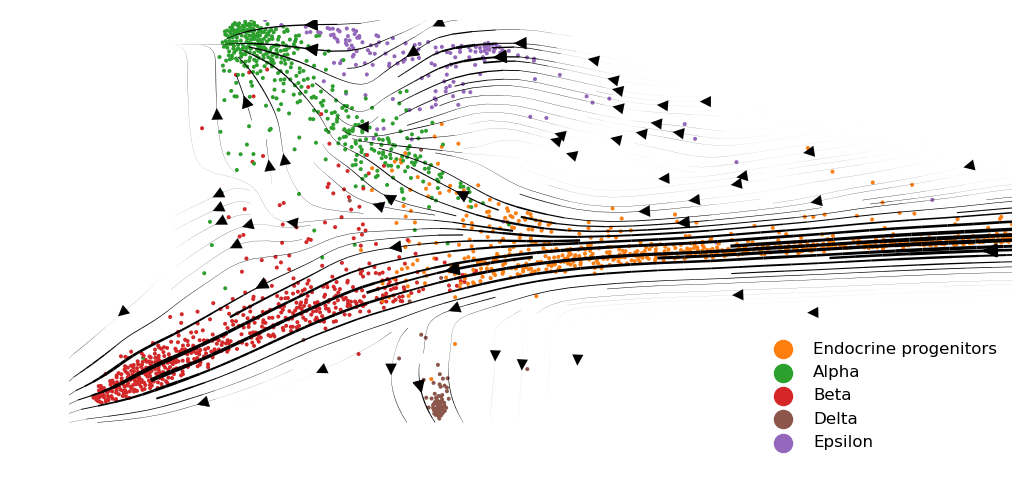

In [15]:
celltypes = ['Endocrine progenitors', 'Alpha', 'Beta', 'Delta', 'Epsilon']

fig, ax = mpl.pyplot.subplots()

scv.pl.velocity_embedding_stream(adata, basis='fa2', alpha=1, title='', density=3, 
                                 legend_fontsize=6, xlim=[-8800, -1000], 
                                 ylim=[-2000, 1500], linewidth=1., size=8, 
                                 legend_loc='best', groups=celltypes, show=False, 
                                 ax=ax, color='celltype', palette=cdict, cutoff_perc=0)

ax.set_aspect('equal')

## iPSCs reprogramming (RNA-seq)

The second part of this tutorial tackles the analysis of a cell reprogramming RNA-seq dataset. Cell reprogramming is a complex biological process aiming to convert cells to induced pluripotent stem cells (iPSC) before differentiation into diverse cell types.

The data comes from [Schiebinger et al., 2019](https://www.sciencedirect.com/science/article/pii/S009286741930039X). The authors obtained Mouse Embryonic Fibroblasts (MEFs) from a single female embryo. They plated MEFs in serum, added Dox on day 0, withdrew Dox on day 8, and transferred cells to either serum-free N2B27 2i medium or maintained them in serum. Hence experiment can be split into Phase 1 (Dox) and Phase 2 (two separate conditions: 2i or serum). Phase 2 lasted till day 18. In this tutorial, you will explore Phase 2's cells in serum condition.

### Loading and preprocessing data

During data preparation, we ran the [Velocyto](http://velocyto.org) on [raw bam files](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE115943), concatenated the resulting loom files into a single h5ad file and filtered it (details in the paper). You can download filtered data [here](https://figshare.com/articles/dataset/Ocelli_Tutorial_4_Exploring_unimodal_data/22700065).

Load the data.

In [1]:
import anndata as ad

adata = ad.read_h5ad('reprogramming_RNAseq.h5ad')

adata

AnnData object with n_obs × n_vars = 68703 × 16817
    obs: 'origin', 'day'

The dataset consists of 68,703 cells and 16,817 genes.

Compute LDA topics and generate topic-based modalities.

In [2]:
import ocelli as oci

SEED = 17

oci.pp.LDA(adata, n_components=20, max_iter=30, random_state=SEED, verbose=1)
oci.pp.modality_generation(adata, verbose=True)

iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30
[modality0]	Modality generated.
[modality1]	Modality generated.
[modality2]	Modality generated.
[modality3]	M

Recall that LDA-based weights are saved in `adata.obsm['weights']`.

In [3]:
adata.obsm['weights']

,modality0,modality1,modality2,modality3,modality4,modality5,modality6,modality7,modality8,modality9,modality10,modality11,modality12,modality13,modality14,modality15,modality16,modality17,modality18,modality19
D10.5_serum_C2_ACGAGCCAGAGATGAG-1,0.018188,0.260103,0.001156,0.009126,0.009408,0.002352,0.029163,0.045946,0.008769,0.022036,0.151197,0.005858,0.002627,0.000785,0.001326,0.002444,0.003475,0.338802,0.083638,0.003604
D10.5_serum_C2_ACAGCTACACTCAGGC-1,0.414483,0.122275,0.001270,0.011122,0.003406,0.002281,0.019959,0.008085,0.003003,0.001095,0.013913,0.007186,0.003591,0.000837,0.001802,0.003269,0.003553,0.277199,0.095757,0.005914
D10.5_serum_C2_AATCCAGGTTAAGAAC-1,0.039830,0.059276,0.002651,0.047478,0.007964,0.014001,0.055219,0.108916,0.004528,0.048911,0.438464,0.014975,0.005923,0.001792,0.009630,0.005973,0.007042,0.034602,0.085691,0.007135
D10.5_serum_C2_AAGGAGCTCGCCAGCA-1,0.253508,0.140598,0.002646,0.023050,0.086551,0.007178,0.023440,0.262014,0.005271,0.032513,0.037204,0.013520,0.005346,0.001750,0.003070,0.021574,0.009583,0.008264,0.037694,0.025226
D10.5_serum_C2_AACGTTGCAAGCCCAC-1,0.030916,0.168546,0.001561,0.004111,0.002640,0.040235,0.091436,0.011523,0.001359,0.003263,0.016181,0.018611,0.004810,0.000868,0.098846,0.007633,0.003684,0.343449,0.144181,0.006150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D9_serum_C2_TTTGTCATCGGTCTAA-1,0.002453,0.031560,0.002408,0.002175,0.219085,0.011649,0.026991,0.008321,0.014884,0.008861,0.096890,0.481740,0.030356,0.001679,0.002245,0.008400,0.021435,0.003019,0.003191,0.022657
D9_serum_C2_TTTGCGCTCTGGTGTA-1,0.002147,0.036475,0.001062,0.000824,0.471827,0.002695,0.001489,0.002531,0.001406,0.005953,0.092982,0.349954,0.004608,0.000769,0.000802,0.011202,0.008510,0.001127,0.000868,0.002770
D9_serum_C2_TTTGGTTAGCGTTCCG-1,0.001865,0.030482,0.002234,0.001204,0.339076,0.005374,0.010248,0.003357,0.008745,0.004399,0.030197,0.464910,0.017090,0.001260,0.001305,0.005885,0.058622,0.001956,0.003050,0.008741
D9_serum_C2_TTTGGTTCACATCCAA-1,0.002554,0.042005,0.003658,0.001548,0.261153,0.010440,0.015073,0.004557,0.062262,0.010299,0.122122,0.346567,0.020403,0.002564,0.001558,0.017506,0.043661,0.003329,0.017770,0.010971


### Multimodal Diffusion Maps

Create a multimodal representation of the dataset with LDA-based weights and MDM.

In [4]:
oci.pp.neighbors(adata, n_neighbors=20, verbose=True)
oci.tl.MDM(adata, n_components=20, save_eigvec=True, save_eigval=True, random_state=SEED,
           verbose=True)

[modality0]	20 nearest neighbors calculated.
[modality1]	20 nearest neighbors calculated.
[modality2]	20 nearest neighbors calculated.
[modality3]	20 nearest neighbors calculated.
[modality4]	20 nearest neighbors calculated.
[modality5]	20 nearest neighbors calculated.
[modality6]	20 nearest neighbors calculated.
[modality7]	20 nearest neighbors calculated.
[modality8]	20 nearest neighbors calculated.
[modality9]	20 nearest neighbors calculated.
[modality10]	20 nearest neighbors calculated.
[modality11]	20 nearest neighbors calculated.
[modality12]	20 nearest neighbors calculated.
[modality13]	20 nearest neighbors calculated.
[modality14]	20 nearest neighbors calculated.
[modality15]	20 nearest neighbors calculated.
[modality16]	20 nearest neighbors calculated.
[modality17]	20 nearest neighbors calculated.
[modality18]	20 nearest neighbors calculated.
[modality19]	20 nearest neighbors calculated.


2023-02-19 00:28:18,122	INFO worker.py:1518 -- Started a local Ray instance.


[modality0]	Unimodal Markov chain calculated.
[modality1]	Unimodal Markov chain calculated.
[modality2]	Unimodal Markov chain calculated.
[modality3]	Unimodal Markov chain calculated.
[modality4]	Unimodal Markov chain calculated.
[modality5]	Unimodal Markov chain calculated.
[modality6]	Unimodal Markov chain calculated.
[modality7]	Unimodal Markov chain calculated.
[modality8]	Unimodal Markov chain calculated.
[modality9]	Unimodal Markov chain calculated.
[modality10]	Unimodal Markov chain calculated.
[modality11]	Unimodal Markov chain calculated.
[modality12]	Unimodal Markov chain calculated.
[modality13]	Unimodal Markov chain calculated.
[modality14]	Unimodal Markov chain calculated.
[modality15]	Unimodal Markov chain calculated.
[modality16]	Unimodal Markov chain calculated.
[modality17]	Unimodal Markov chain calculated.
[modality18]	Unimodal Markov chain calculated.
[modality19]	Unimodal Markov chain calculated.
Multimodal Markov chain calculated.
Eigendecomposition finished.
20 Mu

### Visualizing MDM components with Waddington Optimal Transport

For hair follicle and pancreatic endocrinogenesis datasets, you used scVelo's cell transitions to boost the FLE representation. However, Ocelli can use transitions from any algorithm. Here, you will apply [Waddington Optimal Transport's](https://www.sciencedirect.com/science/article/pii/S009286741930039X) (WOT) precomputed transitions, available for [download](https://broadinstitute.github.io/wot/tutorial/) from the *transport maps* tutorial. We've merged those transitions into a single sparse matrix, which you can download [here](https://figshare.com/articles/dataset/Ocelli_Tutorial_4_Exploring_unimodal_data/22700065).

Load WOT transitions.

In [5]:
from scipy.sparse import load_npz

adata.uns['WOT'] = load_npz('reprogramming_WOT.npz')

Generate a FLE embedding with WOT transitions. Additionally, you can pass a cell timestamp key (from `adata.obs['day']`) to `oci.tl.transitions_graph`. This way, during graph construction, if there are not enough non-zero transitions in a cell's MDM neighborhood, the remaining graph edges connect to the nearest MDM neighbors from the subsequent timestamp, not the global ones.

In [6]:
oci.pp.neighbors(adata, x=['X_mdm'], n_neighbors=100, verbose=True)
oci.tl.transitions_graph(adata, x='X_mdm', transitions='WOT', timestamps='day',
                         n_edges=10, verbose=True)

oci.tl.FA2(adata, n_components=3, n_iter=15000, random_state=SEED)

[X_mdm]	100 nearest neighbors calculated.


23it [00:50,  2.21s/it]


Transitions-based graph constructed.


Feb 19, 2023 10:21:58 AM org.netbeans.modules.masterfs.watcher.Watcher getNotifierForPlatform
INFO: Native file watcher is disabled
Feb 19, 2023 10:22:00 AM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Nodes loaded: 68,703 (68,703 added)
Feb 19, 2023 10:22:00 AM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Edges loaded: 687,030 (607,465 added)


*

************************25%
*************************50%
*************************75%
*************************100%
Time = 2429.21s


Visualize the 3D FLE embedding from multiple perspectives.

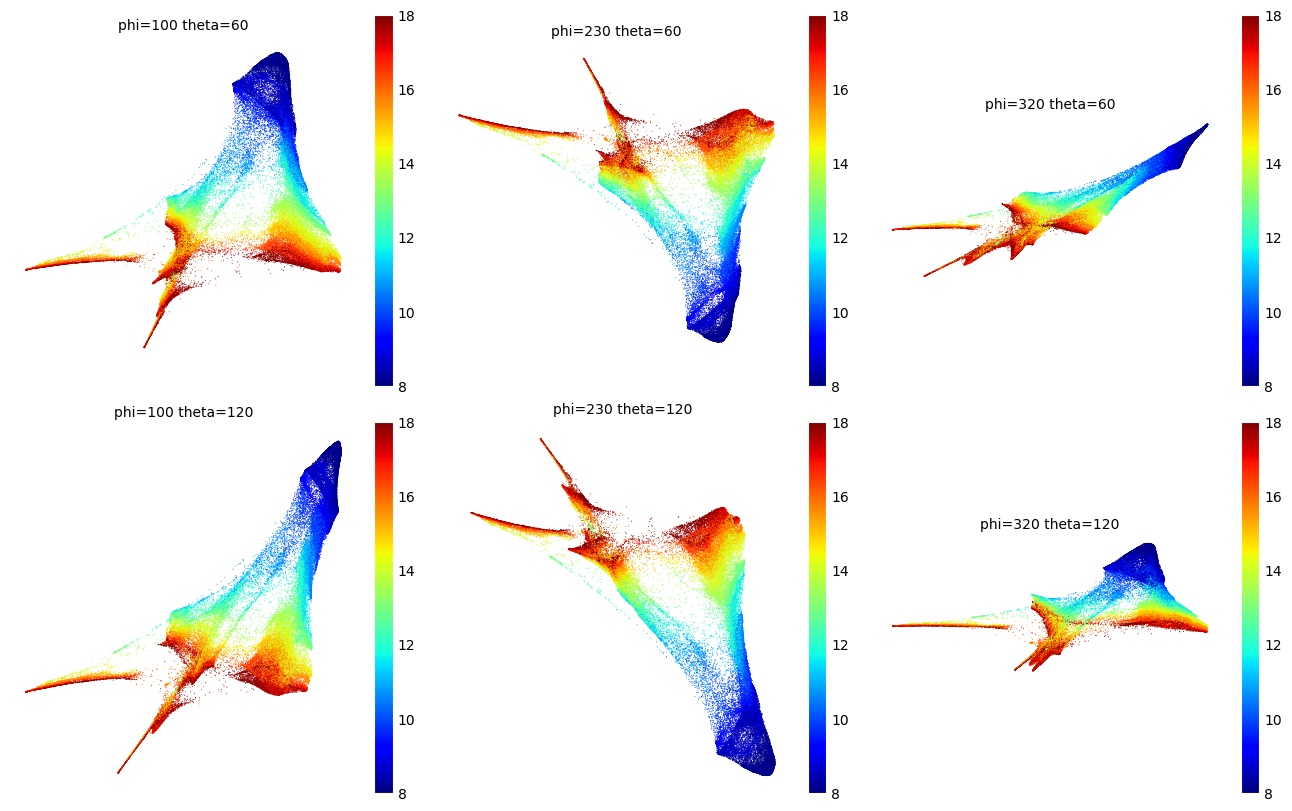

In [7]:
oci.pl.projections(adata, x='X_fa2', c='day', phis=[100, 230, 320], thetas=[60, 120],
                   markersize=0.5, cmap='jet', fontsize=10, figsize=(13, 8))

### Tracing the developmental ancestors of iPSCs

In this tutorial section, you will investigate the development of induced pluripotent stem cells (iPSCs). First, locate pluripotent cells by calculating z-scores for a pluripotency gene signature from [Schiebinger et al., 2019](https://www.sciencedirect.com/science/article/pii/S009286741930039X).

In [8]:
import scanpy as sc
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

# the custom matplotlib colormap
sig_cmap = LinearSegmentedColormap.from_list(
    'custom', ['#e3e3e3','#e3e3e3', '#ff0000', '#000000'], N=256)

# load the raw count matrix and log-normalize it
adata_sig = ad.read_h5ad('reprogramming_RNA.h5ad')
sc.pp.normalize_total(adata_sig, target_sum=10000)
sc.pp.log1p(adata_sig)

# load the signature of gene markers
markers = list(pd.read_csv('reprogramming_signature_Pluripotency.csv', header=None)[0])

# find indices of gene markers in adata_sig.var.index
varnames = list(adata_sig.var.index)

def get_indices(signature, varnames):
    indices = list()
    for gene in signature:
        if gene in varnames:
            indices.append(varnames.index(gene))

    return indices

# compute z-scores
oci.tl.mean_z_scores(adata_sig, markers=get_indices(markers, varnames), 
                     out='Pluripotency')

# save z-scores to adata
adata.obs['Pluripotency'] = adata_sig.obs['Pluripotency']

2023-02-19 15:41:06,603	INFO worker.py:1518 -- Started a local Ray instance.


Plot pluripotency z-scores on the selected projection.

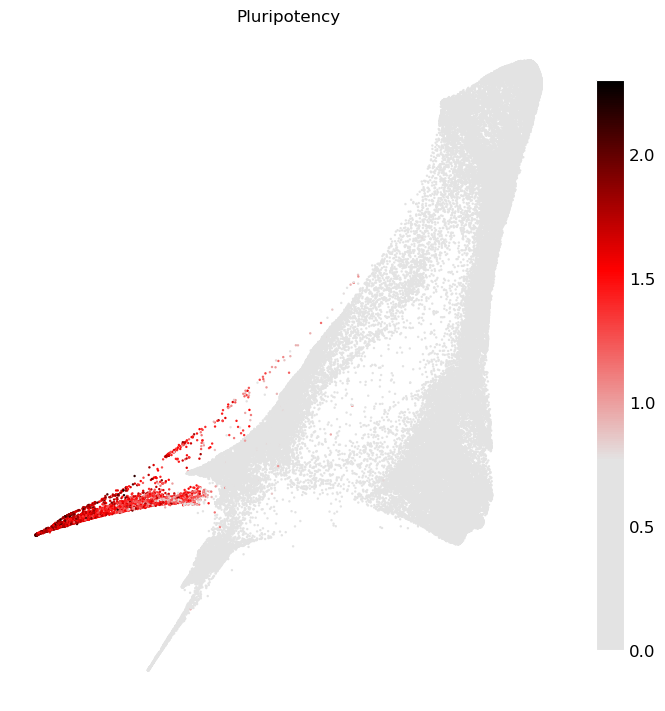

In [9]:
oci.tl.projection(adata, x='X_fa2', phi=230, theta=125)

oci.pl.scatter(adata, x='X_proj', c='Pluripotency', cmap=sig_cmap, markersize=3,
               markerscale=2, fontsize=12, figsize=(7, 7), title='Pluripotency',
               vmin=0)

You have located pluripotent cells. Now, mark cells with the highest pluripotency z-scores.

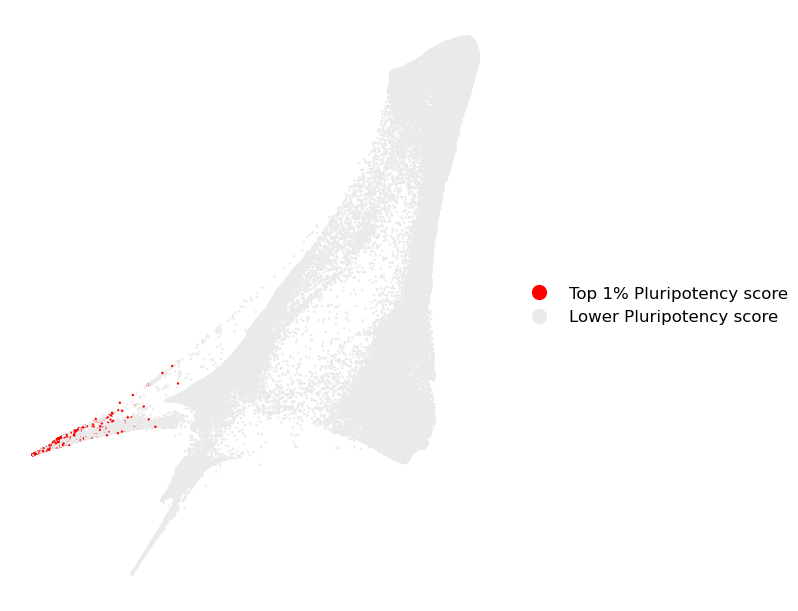

In [10]:
import numpy as np

thr = np.percentile(adata.obs['Pluripotency'], 99)

mask_Pluripotency = list()
for v in adata.obs['Pluripotency']:
    if v > thr:
        mask_Pluripotency.append('Top 1% Pluripotency score')
    else:
        mask_Pluripotency.append('Lower Pluripotency score')
adata.obs['mask_Pluripotency'] = mask_Pluripotency

cdict = {'Top 1% Pluripotency score': '#ff0000', 
         'Lower Pluripotency score': '#eaeaea'}

oci.pl.scatter(adata, x='X_proj', c='mask_Pluripotency', cdict=cdict, markersize=3, 
               markerscale=2, fontsize=12, figsize=(8, 6), title='', vmin=0)

Create a vector with 1s assigned to 1% of cells with the highest z-scores and 0s to others.

In [11]:
v = np.asarray([1 if val == 'Top 1% Pluripotency score' else 0 for val in adata.obs['mask_Pluripotency']])

You can trace the developmental ancestors of pluripotent cells by iteratively diffusing `v` with the square WOT transition matrix `M`. `t`-step diffusion can be written as `M^t * v`.

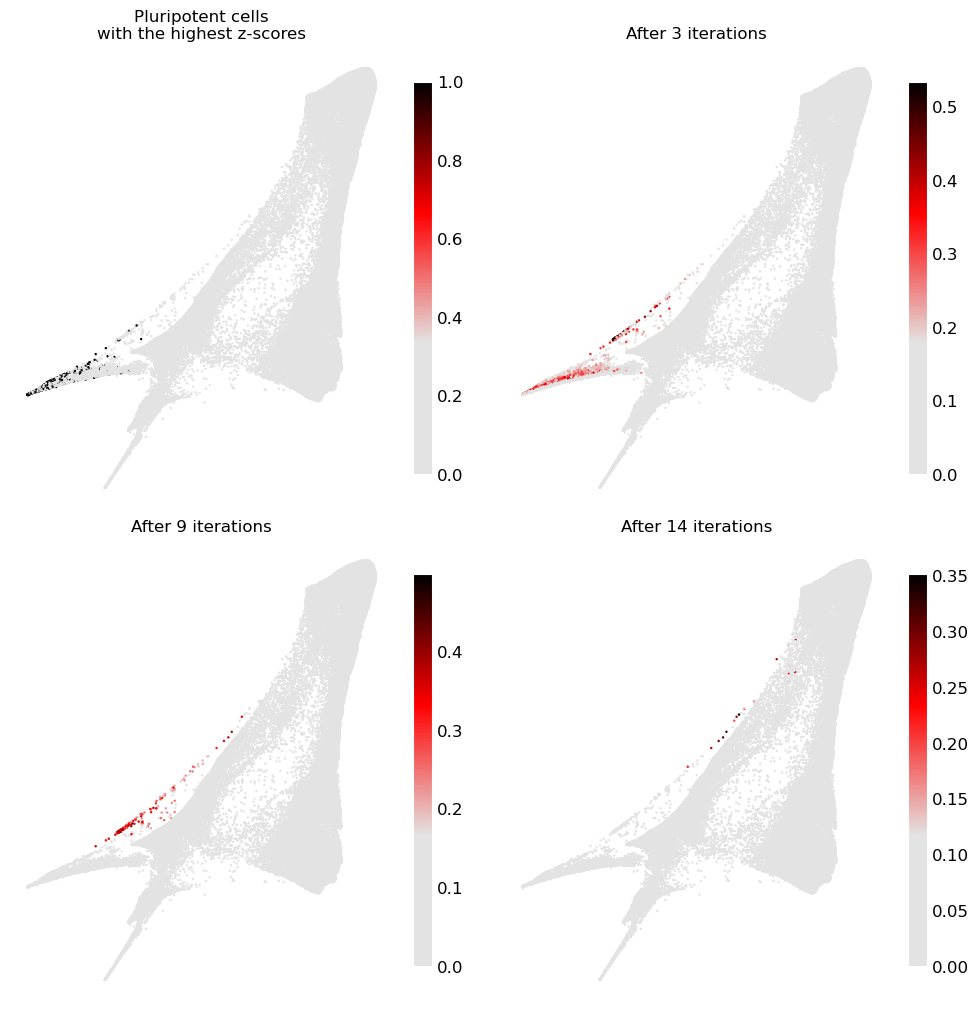

In [12]:
from tqdm import tqdm

n_iterations = 14
M = adata.uns['WOT']

vs = [v]

for i in range(n_iterations):
    v = M.dot(v)
    if i in [2, 8, 13]:
        vs.append(v)
    
adata.obsm['ancestors'] = pd.DataFrame(np.asarray(vs).T, 
                                       index=adata.obs.index,
                                       columns=['Pluripotent cells\nwith the highest z-scores',
                                                'After 3 iterations',
                                                'After 9 iterations', 
                                                'After 14 iterations'])

oci.pl.scatter(adata, x='X_proj', c='ancestors', cmap=sig_cmap, markersize=3,
               markerscale=0.05, fontsize=12, figsize=(10, 10), vmin=0, ncols=2)

MDM reconstructed a clear ancestor trajectory of iPSCs in serum condition.

### Sensitivity to rare cell populations

Lastly, compute and plot z-scores for the gene signature from [Schiebinger et al., 2019](https://www.sciencedirect.com/science/article/pii/S009286741930039X) of a rare population of XEN cells.

2023-02-19 15:42:24,617	INFO worker.py:1518 -- Started a local Ray instance.


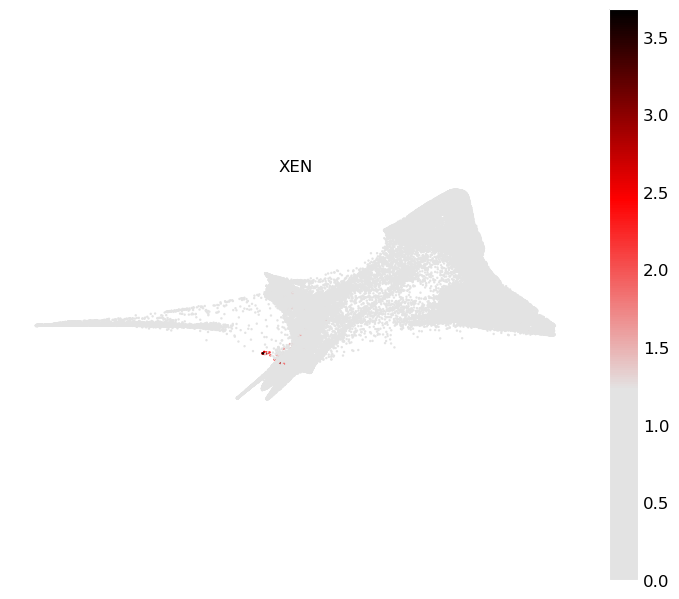

In [13]:
oci.tl.projection(adata, x='X_fa2', phi=320, theta=120)

markers = list(pd.read_csv('reprogramming_signature_XEN.csv', header=None)[0])
oci.tl.mean_z_scores(adata_sig, markers=get_indices(markers, varnames), out='XEN')
adata.obs['XEN'] = adata_sig.obs['XEN']

oci.pl.scatter(adata, x='X_proj', c='XEN', cmap=sig_cmap, markersize=3, markerscale=2,
               fontsize=12, figsize=(7, 6), title='XEN', vmin=0)

Now you can easily use Ocelli for your single-cell analyses. Good luck!